# Solar-System Problem :   WorkPrecision

<ul id="top">
<li><a href="#Loading-packages"> 
             Loading Packages</a></li>
    
<li><a href="#Computer-properties"> 
             Computer properties</a></li>  

<li><a href="#Initial-value-problem:-Solar-System">
             Initial value problem: Solar-System</a></li>

<li><a href="#Test-solution">
             Test solution</a></li>
             
<li><a href="#Work-Precision-diagrams-(Float64)">
             Work-Precision diagrams (Float64)</a></li> 
             
<li><a href="#Save/Load-Data">
            Save/Load Data</a></li>  

</ul>  

In the following file, the following functions are defined: NbodyEnergy(u,Gm), NbodyODE!(du,u,Gm,t),  where

$$
u = 
\left(\begin{matrix}
v_1 & \cdots & v_N\\
q_1 & \cdots & q_N
\end{matrix}
\right) \in \mathbb{R}^{2 \times 3\times N}, \quad
Gm = (G\,  m_1, \ldots,G\,  m_N) \in \mathbb{R}^N.
$$


The energy, as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
$$
\begin{split}
\mathrm{Energy}(q_1,\ldots,q_N,v_1,\ldots,v_N) = 
\frac12 \sum_{i=1}^{N} m_i \, \|v_i\|^2
- G \sum_{1\leq i < j \leq N} \frac{m_i m_j}{\|q_i-q_j\|}.
\end{split}
$$


The ODE system of the N-body problem,
as a function of the positions $q_1,\ldots,q_N \in \mathbb{R}^3$ and the velocities $v_1,\ldots,v_N \in \mathbb{R}^3$ of the $N$ bodies is:
$$
\begin{split}
\frac{d}{dt} q_i &= v_i, \\
\frac{d}{dt} v_i &= G\, 
\sum_{j \neq i} \frac{m_j}{\|q_j-q_i\|^3}\,
(q_j-q_i).
\end{split}
$$
This system of ODEs can be writen in compact form as
$$
\frac{d u}{dt} = f(t,u,Gm)
$$

We consider $N=9$ bodies of solar system: the Sun, Mercury, Venus, Earth-Moon, Mars, Jupiter, Saturn, Uranus, Neptune,  Pluto.
The initial values $u_0$ are taken from DE430, Julian day (TDB) 2440400.5 (June 28, 1969).

## Loading packages

In [1]:
using OrdinaryDiffEq,DiffEqDevTools,BenchmarkTools
using Plots,LinearAlgebra
using Dates
using JLD2, FileIO
using RecursiveArrayTools
using IRKGaussLegendre


<a href="#top">Back to the top</a>

## Computer properties

In [2]:
#export JULIA_NUM_THREADS=2
Threads.nthreads()

4

In [3]:
#;cat /proc/cpuinfo # on Linux machines

In [4]:
using Hwloc
Hwloc.num_physical_cores()

8

<a href="#top">Back to the top</a>

## Initial value problem: Solar-System

In [5]:
setprecision(BigFloat, 108);
include("../ODEProblems/Nbody.jl")
include("../ODEProblems/InitialNBody9.jl")

dt=5.
t0=0.0
t1=20*dt    #20, 1000.
t1=1000.
mysaveat=1  #10
vsaveat=dt

u064,Gm64 =InitialNBody9(Float64)
lpp=Gm64
tspan64=(t0,t1)
prob64 = ODEProblem(NbodyODE!,u064,tspan64,Gm64);

u0128,Gm128=InitialNBody9(BigFloat)
tspan128=(BigFloat(t0),BigFloat(t1))
prob128 = ODEProblem(NbodyODE!,u0128,tspan128,Gm128)

q064=u064[2,:,:]
v064=u064[1,:,:]
probdyn64 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q064,v064,tspan64,Gm64);
prob2nd64 = SecondOrderODEProblem(NbodyODE2nd!,v064,q064,tspan64,Gm64);


q0128=u0128[2,:,:]
v0128=u0128[1,:,:]
probdyn128 = DynamicalODEProblem(NbodyODEq!,NbodyODEv!,q0128,v0128,tspan128,Gm128);
prob2nd128 = SecondOrderODEProblem(NbodyODE2nd!,v0128,q0128,tspan128,Gm128);


mysaveat=10
vsaveat=0.1;

(typeof(u064),typeof(Gm64),typeof(tspan64),typeof(u0128),typeof(Gm128),typeof(tspan128))

(Array{Float64, 3}, Vector{Float64}, Tuple{Float64, Float64}, Array{BigFloat, 3}, Vector{BigFloat}, Tuple{BigFloat, BigFloat})

<a href="#top">Back to the top</a>

## Test solution

In [6]:
setprecision(BigFloat, 256)

#sol =solve(prob128,Vern9(),save_everystep=false, abstol=1e-32,reltol=1e-32);
#@save "./Data/Solar_System_solT1000.jld2" sol


@load "./Data/Solar_System_solT1000.jld2" sol
test_sol = TestSolution(sol)
sol.destats

u0256,Gm256=InitialNBody9(BigFloat)

E0=NbodyEnergy(u0256,Gm256)

(Float32(sol.t[end]),Float32(NbodyEnergy(sol.u[end],Gm256)/E0-1))

(1000.0f0, -9.080402f-34)

In [7]:
ux=sol.u[end]
solx=ArrayPartition(ux[2,:,:],ux[1,:,:])
test_solx = TestSolution(tspan128,[solx]);

ux=sol.u[end]
solx2nd=ArrayPartition(ux[1,:,:],ux[2,:,:])
test_solx2nd = TestSolution(tspan128,[solx2nd]);

<a href="#top">Back to the top</a>

## Work-Precision diagrams (Float64)

In [8]:
abstols = 1.0 ./ 10.0 .^ (10:19)
reltols = 1.0 ./ 10.0 .^ (10:19)

dts=16*0.866.^(0:length(reltols)-1);

### Second Order Problem: Vern9, IRKGL16

In [9]:
setups = [
          Dict(:alg=>Vern9())
          Dict(:alg=>IRKGL16(),:adaptive=>false,:dts=>dts)
          Dict(:alg=>IRKGL16(threading=true),:adaptive=>false,:dts=>dts) 
]
solnames = ["Vern9","IRKGL16-fixed","IRKGL16-fixed (threads)"]
wp2 = WorkPrecisionSet(probdyn64,abstols,reltols,setups;appxsol=test_solx,save_everystep=false,numruns=1,maxiters=10^9, names=solnames);

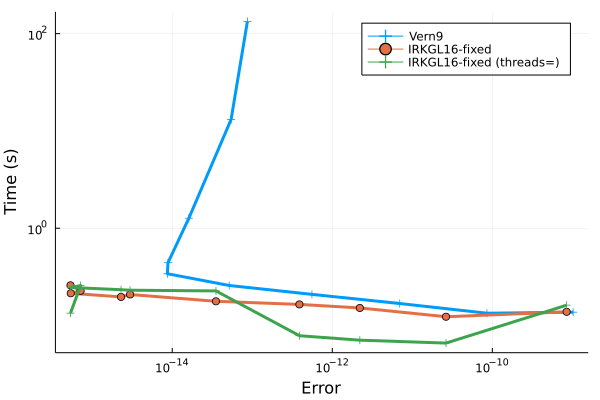

In [10]:
plot(wp2)

### SecondOrderProblem: DPRKN12

In [11]:
setups = [
          Dict(:alg=>DPRKN12())   
]
solnames = ["DPRKN12"]
wp3 = WorkPrecisionSet(prob2nd64,abstols,reltols,setups;appxsol=test_solx2nd,save_everystep=false,numruns=1,maxiters=10^9,names=solnames);

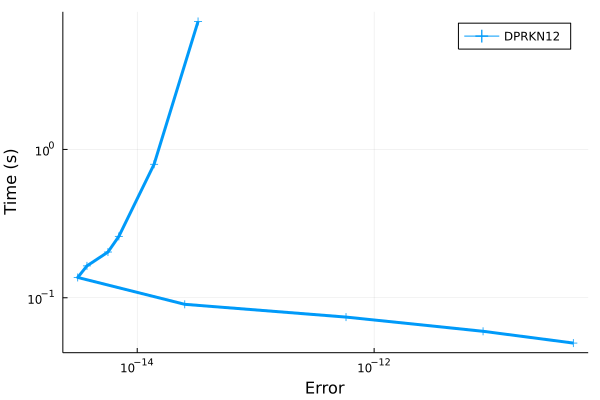

In [12]:
plot(wp3)

### All methods in one Plot

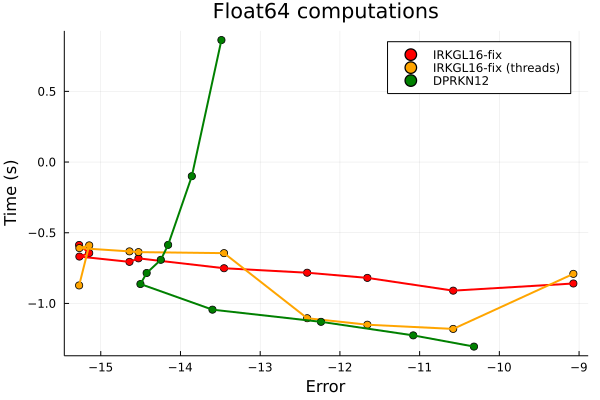

In [13]:
plot(title="Float64 computations",xlabel="Error", ylabel="Time (s)")
#k=1
#plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="Vern9", color="blue")
#plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="",lw=2, color="blue")
# 
k=2
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16-fix",color="red")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="red")
#
k=3
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), seriestype=:scatter, label="IRKGL16-fix (threads)",color="orange")
plot!(log10.(wp2.wps[k].errors),log10.(wp2.wps[k].times), label="", lw=2, color="orange")
#
k=1
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), seriestype=:scatter, label="DPRKN12",color="green")
plot!(log10.(wp3.wps[k].errors),log10.(wp3.wps[k].times), label="", lw=2, color="green")

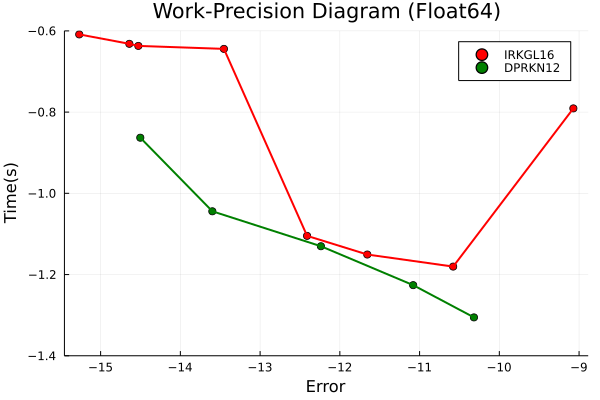

In [14]:
plot(title="Work-Precision Diagram (Float64)", xlabel="Error",ylabel="Time(s)",ylimit=(-1.4,-0.6),size= (600,400))
k=3
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), seriestype=:scatter, label="IRKGL16",color="red")
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), seriestype=:scatter, label="DPRKN12",color="green")
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), label="", lw=2, color="green")

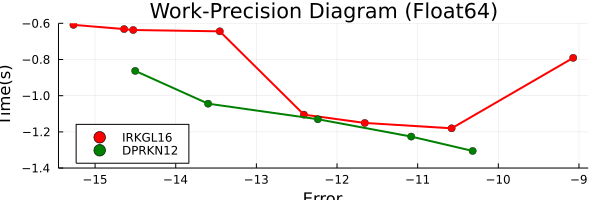

In [15]:
plot(title="Work-Precision Diagram (Float64)", xlabel="Error",ylabel="Time(s)",ylimit=(-1.4,-0.6),size=(600,200),legend=:bottomleft)
k=3
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), seriestype=:scatter, label="IRKGL16",color="red")
plot!(log10.(wp2.wps[k].errors[1:8]),log10.(wp2.wps[k].times[1:8]), label="", lw=2, color="red")
#
k=1
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), seriestype=:scatter, label="DPRKN12",color="green")
plot!(log10.(wp3.wps[k].errors[1:5]),log10.(wp3.wps[k].times[1:5]), label="", lw=2, color="green")

### Choosing  tol and step-size for comparable execution time

In [16]:
#
# DPRKN12     tol=1e-13
#
fieldnames(typeof(wp3))
fieldnames(typeof(wp3.wps[1]))
(wp3.wps[1].errors[4],wp3.wps[1].abstols[4],wp3.wps[1].times[4])

(2.5188742307833537e-14, 1.0e-13, 0.090319226)

In [17]:
#
# IRKGL16    dt=5.85
#
fieldnames(typeof(wp2.wps[3]))
(wp2.wps[3].errors[8],dts[8],wp2.wps[3].times[8])

(5.395230858630899e-16, 5.8444712523555555, 0.246183052)

<a href="#top">Back to the top</a>

### Save/Load Data

In [21]:
# Float64 experiments
#@save "./Data/output/OutNBody9_wp2.jld2" wp2
#@save "./Data/output/OutNBody9_wp3.jld2" wp3

In [19]:
# Float64 experiments
#@load "./Data/output/OutNBody9_wp2.jld2" wp2
#@load "./Data/output/OutNBody9_wp3.jld2" wp3

In [20]:
now()

2022-08-05T20:46:16.690